# California Housing Prices

Build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them "districts" for short.

Your model should learn from this data and be able to **predict the median house value** in any district, given all the other metrics.

## Problem description

Given that all the data needed for this problem is available in one CSV file. Given we have to predict a numeric target attribute which is also provided in the data as a label, we'll need to build a **supervised regression model** with a **offline** approach.

## Data overview

In [1]:
import pandas as pd
import numpy as np

In [2]:
housing = pd.read_csv('housing.csv')

In [3]:
housing.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 2.5 MB


In [4]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

> You can check whether a column classified as `float` has integer numbers. The following command tells you whether all values are integers or there is at least one floating number.
>
> ```
> (housing['housing_median_age'] % 1 == 0).all()
> ```
>
> If the column has missing values, you can run
>
> ```
> (housing.dropna()['total_bedrooms'] % 1 == 0).all()
> ```
>
> The `dropna` removes the `NaN` values because the `% 1` operation on NaN doesn't equal zero, and this statement will return `False`.

In [6]:
housing[['ocean_proximity']].describe()

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [7]:
pd.DataFrame(housing['ocean_proximity'].value_counts())

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


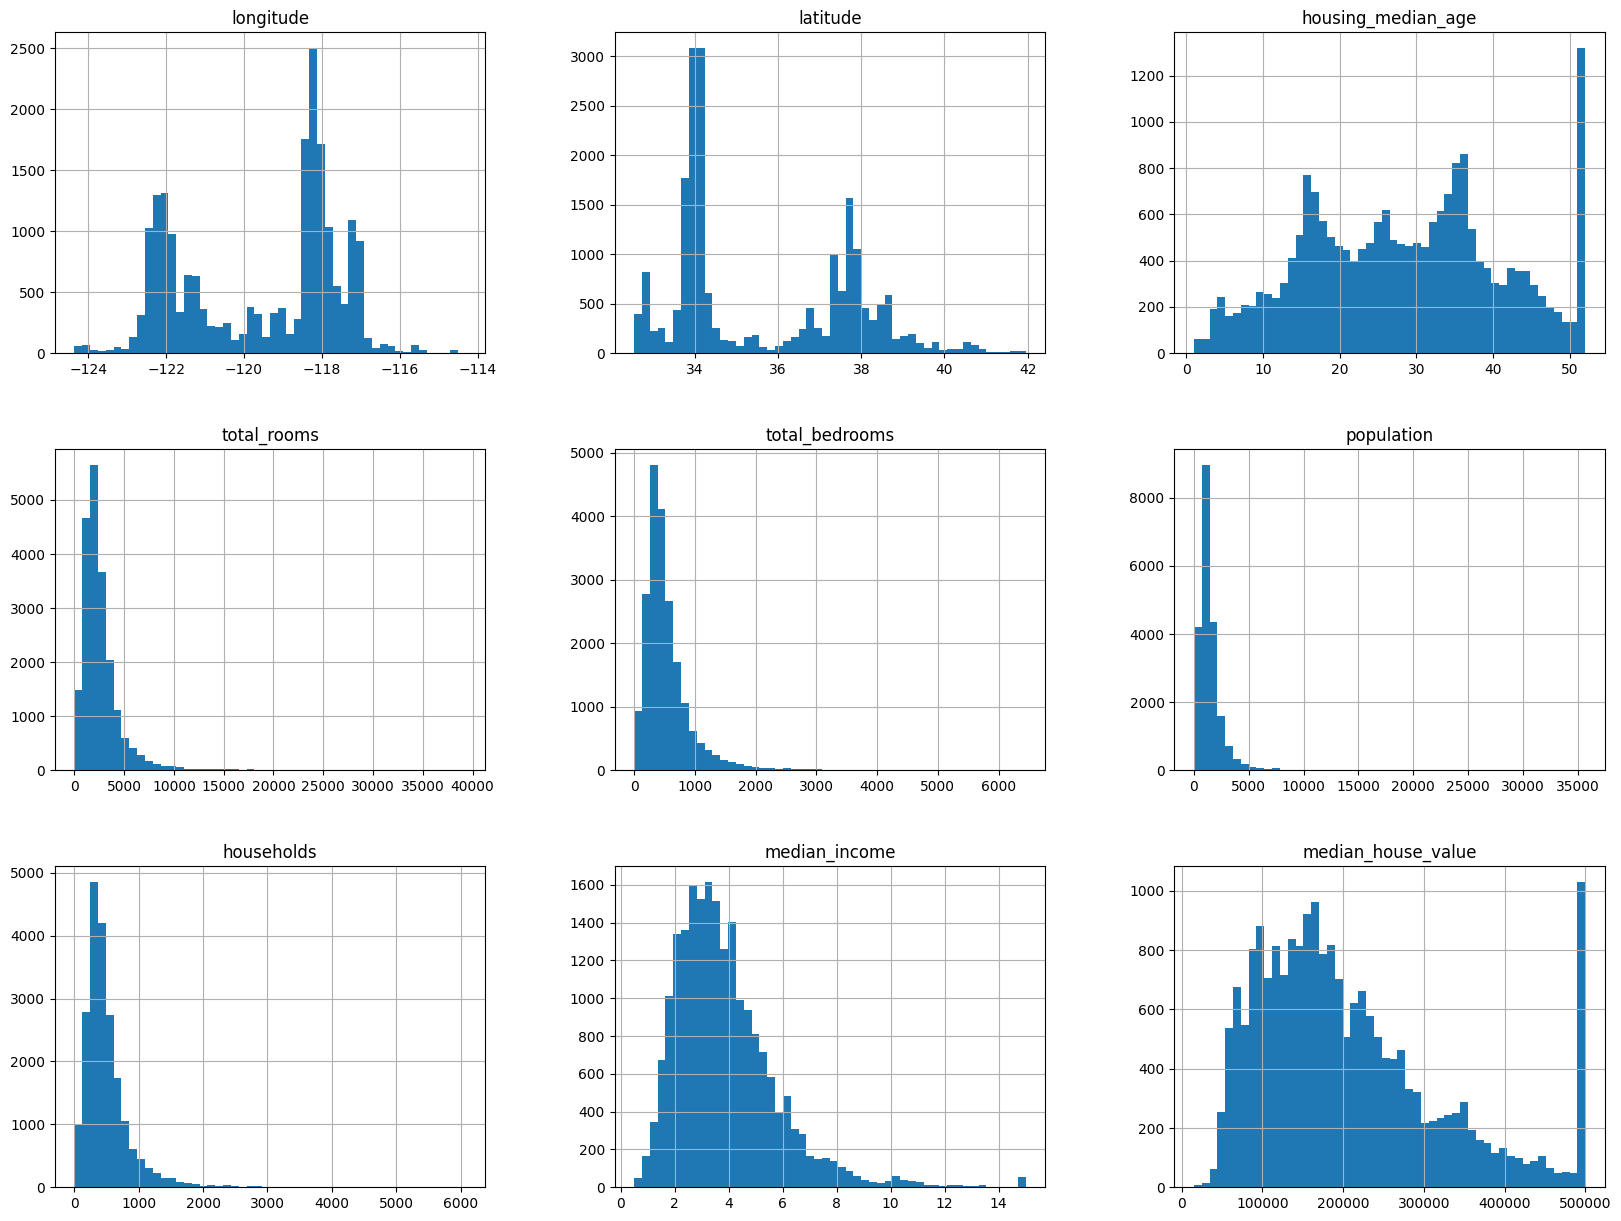

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Create Training and Test sets

By setting aside a portion of the dataset as a test set at this stage, prevents the so called ***data snooping bias***.

By splitting the dataset, we need to make sure that the `median_income` is represented in the same percentage in both the test and training set, because it is an important predictor.

array([[<Axes: title={'center': 'median_income'}>]], dtype=object)

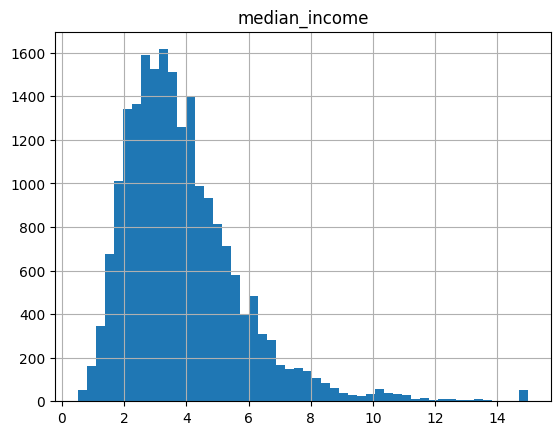

In [9]:
housing[['median_income']].hist(bins=50)

In [10]:
housing['median_income_categories'] = pd.cut(
    housing['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)
pd.DataFrame(housing[['median_income_categories']].value_counts(), columns=['Occurrences'])

,Occurrences


<Axes: >

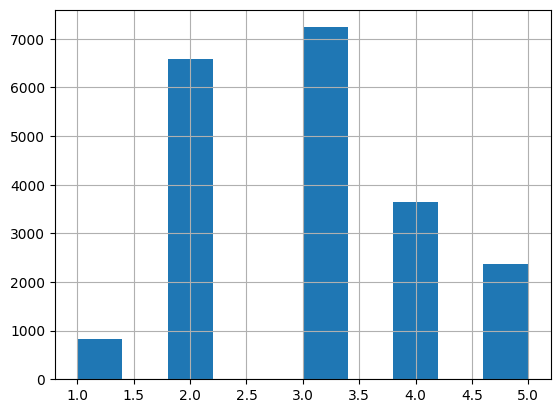

In [11]:
housing['median_income_categories'].hist()

we can now perform stratified sampling based on the new categorical attribute

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['median_income_categories']):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

Let's verify that the percentage of each income category is equal on both sets

In [13]:
train_set['median_income_categories'].value_counts() / len(train_set)

median_income_categories
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [14]:
test_set['median_income_categories'].value_counts() / len(test_set)

median_income_categories
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Now we remove the income category we created solely to split the data

In [15]:
train_set = train_set.drop('median_income_categories', axis=1)
test_set = test_set.drop('median_income_categories', axis=1)

## Visualise geographical data

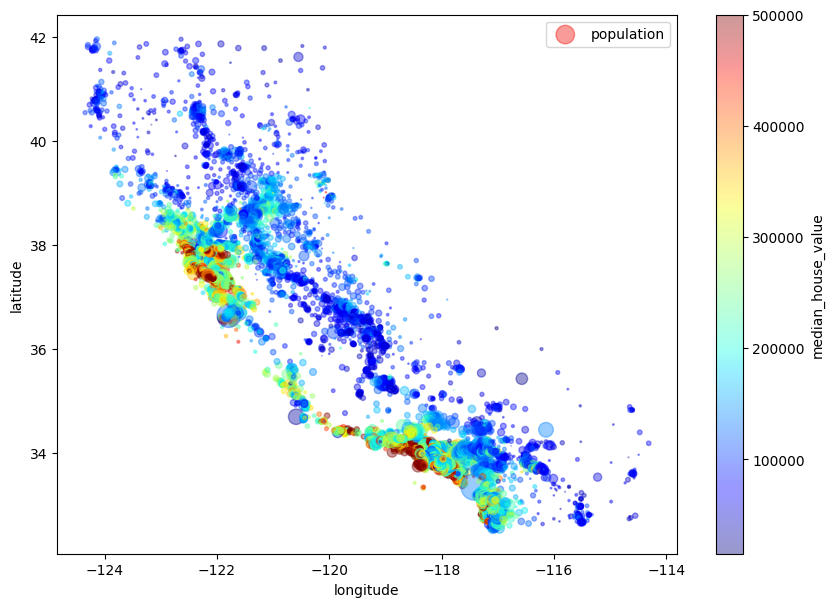

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

## Correlation coefficient

In [17]:
corr_matrix = housing.corr(method='pearson', numeric_only=True)

Now let’s look at how much each attribute correlates with the median house value:

In [18]:
pd.DataFrame(corr_matrix["median_house_value"].sort_values(ascending=False))

,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


The correlation coefficient ranges from –1 to 1.

When it is close to 1, it means that there is a strong positive correlation.

When it is close to –1, it means that there is a strong negative correlation.

Coefficients close to zero mean that there is no linear correlation.

The **correlation coefficient** only measures linear correlations but it may completely miss out on nonlinear relationships. For example, if `x` is close to zero then `y` generally goes up

## Scatter matrix

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

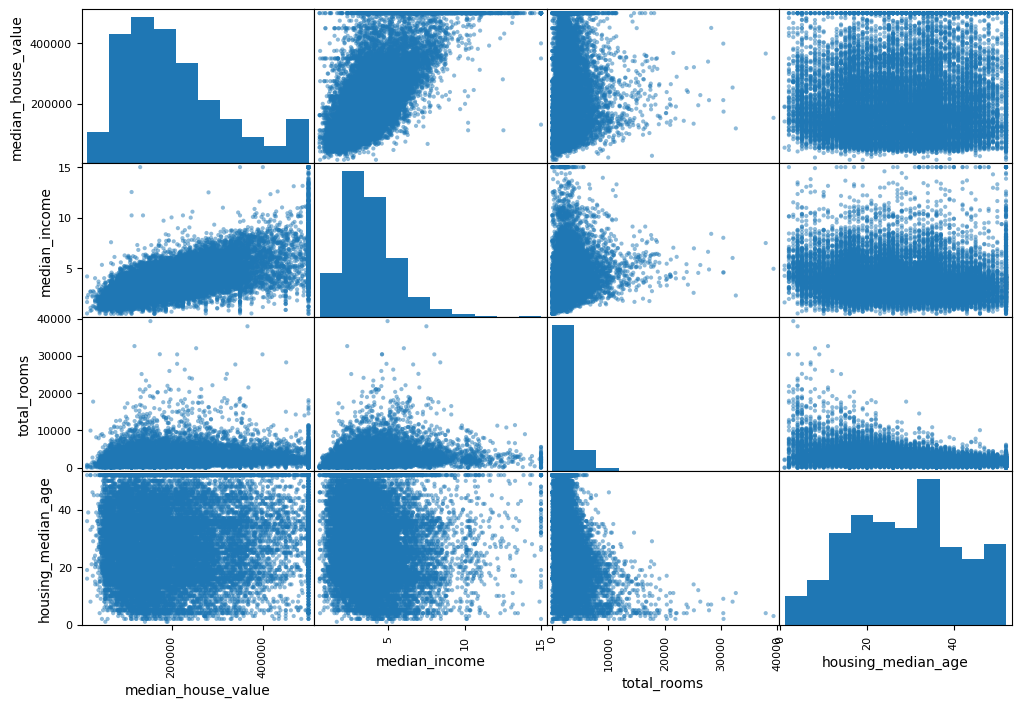

In [19]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8))

This matrix is specular, so we can just concentrate on the graphs below (or above) the diagonal.

The most promising attribute to predict the median house value is the median income

<Axes: xlabel='median_income', ylabel='median_house_value'>

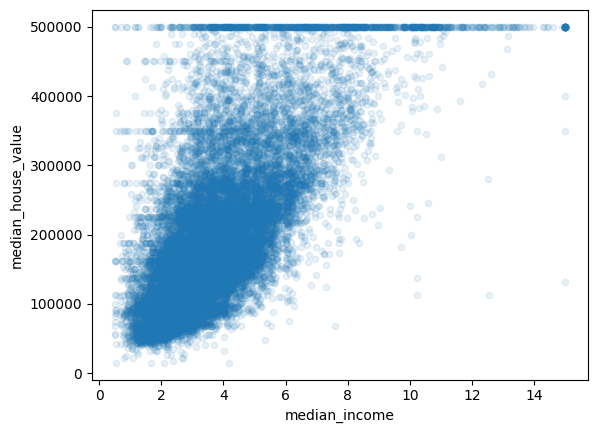

In [20]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

## Feature engineering

In [21]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"]= housing["population"] / housing["households"]

In [22]:
pd.DataFrame(corr_matrix["median_house_value"].sort_values(ascending=False))

,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


Notice how the `bedrooms_per_room` calculated property bumps up in the correlation in respects to the `total_bedrooms` attribute.

## Data cleaning

In [23]:
X_train = train_set.drop('median_house_value', axis=1)
y_train = train_set['median_house_value'].copy()

In [24]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train_num = X_train.drop("ocean_proximity", axis=1)

In [25]:
imputer.fit(X_train_num)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [26]:
X = imputer.transform(X_train_num)
pd.DataFrame(X, columns=X_train_num.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [27]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

X_train_cat = X_train[["ocean_proximity"]].copy()
X_train_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


In [28]:
cat_encoder.fit_transform(X_train_cat)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [29]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]